# neural density estimation --- normalizing flows
In this notebook, we'll implement a few normalizing flows! 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np 

import matplotlib.pyplot as plt
import corner

In [2]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


# synthetic data
Lets use the same gnarly distirbution as in the MADE example

In [3]:
def make_synthetic_data(N, D, device="cpu"):
    """
    More challenging synthetic data for D >= 4:

    - (x0, x1): 3-component Gaussian mixture with different means & covariances
                (including rotated, anisotropic components)
    - x2: nonlinear function of (x0, x1) + noise
          x2 = sin(x0) + 0.5 * x1^2 + eps
    - x3: heavy-tailed (Student-t-like) variable
    - If D > 4, remaining dims are weakly correlated noisy copies.
    """

    assert D >= 4, "This generator assumes at least 4 dimensions."

    # ----- 3-component mixture in (x0, x1) -----
    # Means
    mus = torch.stack([
        torch.tensor([0.0, 0.0], device=device),
        torch.tensor([3.0, -3.0], device=device),
        torch.tensor([-3.0, 3.0], device=device),
    ])  # [3, 2]

    # Covariance matrices (anisotropic + rotated)
    covs = []
    # Component 0: roughly isotropic
    covs.append(torch.tensor([[1.0, 0.2],
                              [0.2, 1.0]], device=device))
    # Component 1: elongated and rotated
    covs.append(torch.tensor([[2.0, 1.5],
                              [1.5, 2.0]], device=device))
    # Component 2: narrow and rotated differently
    covs.append(torch.tensor([[0.5, -0.3],
                              [-0.3, 0.5]], device=device))
    covs = torch.stack(covs, dim=0)  # [3, 2, 2]

    # Mixing probabilities (non-uniform)
    pis = torch.tensor([0.4, 0.35, 0.25], device=device)

    # Sample component indices
    # Multinomial over {0,1,2}
    comp_idx = torch.multinomial(pis, num_samples=N, replacement=True)  # [N]

    # For each sample, get its mean and covariance
    mu = mus[comp_idx]           # [N, 2]
    cov = covs[comp_idx]         # [N, 2, 2]

    # Sample from N(0, I) and transform via Cholesky of cov
    eps = torch.randn(N, 2, device=device)  # [N, 2]
    # Cholesky factor per component
    L = torch.linalg.cholesky(cov)          # [N, 2, 2]
    xy = (L @ eps.unsqueeze(-1)).squeeze(-1) + mu  # [N, 2]

    x0 = xy[:, 0]
    x1 = xy[:, 1]

    # ----- Nonlinear, noisy x2 -----
    # x2 = sin(x0) + 0.5 * x1^2 + noise
    noise_x2 = 0.5 * torch.randn(N, device=device)
    x2 = torch.sin(x0) + 0.5 * x1**2 + noise_x2

    # ----- Heavy-tailed x3 (Student-t like) -----
    # t-dist ~ z / sqrt(u/ν), with z ~ N(0,1), u ~ χ²(ν)
    nu = 3.0
    z = torch.randn(N, device=device)
    u = torch.distributions.Chi2(df=torch.tensor(nu, device=device)).sample((N,))
    x3 = z * torch.sqrt(nu / u)  # Student-t(ν)

    # Stack first 4 dims
    x = torch.stack([x0, x1, x2, x3], dim=-1)  # [N, 4]

    # ----- If D > 4: add weakly correlated extra dims -----
    if D > 4:
        extra_dims = []
        for d in range(D - 4):
            # Each additional dim is a noisy linear combo of (x0, x1, x2, x3)
            w = torch.randn(4, device=device)
            extra = (x @ w) / torch.sqrt(torch.sum(w**2))  # normalized
            extra += 0.3 * torch.randn(N, device=device)   # extra noise
            extra_dims.append(extra.unsqueeze(-1))
        extra_dims = torch.cat(extra_dims, dim=-1)  # [N, D-4]
        x = torch.cat([x, extra_dims], dim=-1)      # [N, D]

    return x

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_73370/598188881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))


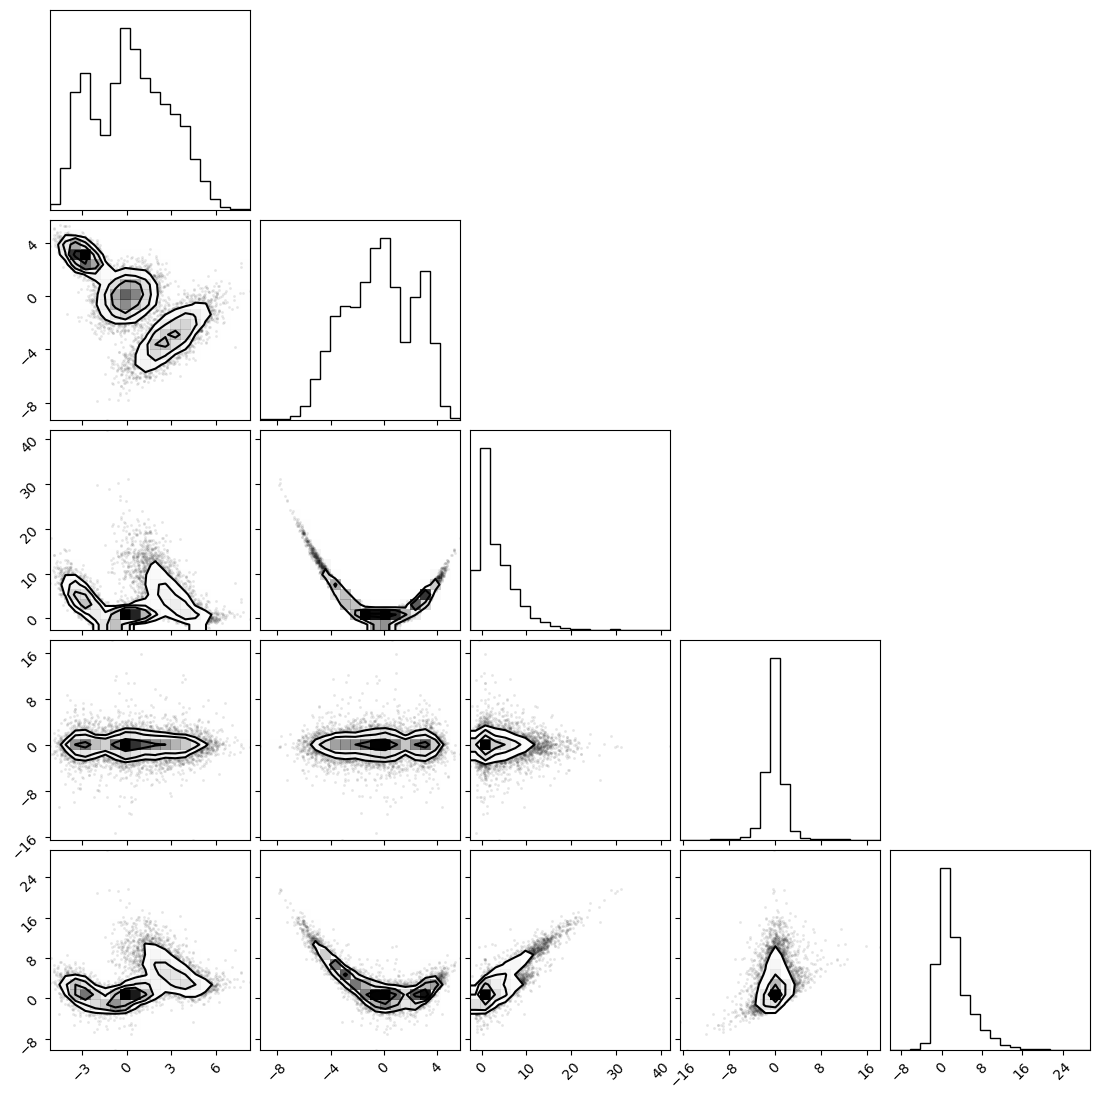

In [4]:
samples = make_synthetic_data(10000, 5, device='cpu')
fig = corner.corner(np.array(samples))

# Flow 1: Planar flow
Lets start with one of the simplest normalizing flow: the planar flow.

In [8]:
class PlanarFlow(nn.Module):
    '''planar normalizing flow
    '''
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        self.u = nn.Parameter(torch.zeros(dim))
        self.w = nn.Parameter(torch.zeros(dim))
        self.b = nn.Parameter(torch.zeros(())) 

        # initialize
        nn.init.normal_(self.u, mean=0.0, std=0.01)
        nn.init.normal_(self.w, mean=0.0, std=0.01)
        nn.init.zeros_(self.b)

    def _u_hat(self):
        ''' Reparameterization of u to enforce invertibility:
            u_hat = u + (m - a(w^T u)) * w / ||w||^2
        with m = -1, a(x) = -1 + log(1 + e^x).
        '''
        wtu = torch.dot(self.w, self.u)  # scalar
        # a(x) = softplus(x) - 1
        a = -1.0 + F.softplus(wtu)
        m = -1.0
        w_norm_sq = torch.sum(self.w ** 2)
        u_hat = self.u + (m - a) * self.w / (w_norm_sq + 1e-8)
        return u_hat

    def forward(self, z):
        u_hat = self._u_hat()                     # [dim]
        w = self.w                                # [dim]
        b = self.b                                # scalar

        # w^T z + b  -> [batch]
        linear = z @ w + b
        h = torch.tanh(linear)                    # [batch]

        # z' = z + u_hat * h
        x = z + h.unsqueeze(1) * u_hat        # [batch, dim]

        # psi(z) = h'(linear) * w, where h' = 1 - tanh^2
        h_prime = 1.0 - torch.tanh(linear) ** 2   # [batch]
        psi = h_prime.unsqueeze(1) * w           # [batch, dim]

        # log |1 + u_hat^T psi|
        u_hat_psi = torch.sum(psi * u_hat, dim=1)  # [batch]
        log_det = torch.log(torch.abs(1.0 + u_hat_psi) + 1e-8)

        return x, log_det

    def log_prob(self, z):
        """
        Standard Normal N(0, I) log density.
        z: [batch, dim]
        returns: [batch]
        """
        _, log_det = self.forward(z)
        
        return -0.5 * (self.dim * np.log(2 * np.pi) + torch.sum(z ** 2, dim=1)) + log_det

In [10]:
D = samples.shape[1]
lr = 1e-3
batch_size = 128
num_epochs = 100

flow = PlanarFlow(D).to(device)

optimizer = optim.Adam(flow.parameters(), lr=lr)

# Data
x_train = samples.to(device) 
N_train = samples.shape[0]

num_batches = N_train // batch_size
train_losses = []
for epoch in range(1, num_epochs + 1):
    # Shuffle train data
    perm = torch.randperm(N_train, device=device)
    x_train = x_train[perm]

    flow.train()
    epoch_loss = 0.0

    for i in range(num_batches):
        batch_x = x_train[i * batch_size:(i + 1) * batch_size]
        optimizer.zero_grad()
        lp = flow.log_prob(batch_x)      # [batch]
        loss = -lp.mean()                  # NLL
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= num_batches
    train_losses.append(epoch_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: train log p = {epoch_loss:.4f}")

Epoch 001: train log p = 32.6045
Epoch 005: train log p = 31.8985
Epoch 010: train log p = 31.7191
Epoch 015: train log p = 31.6329
Epoch 020: train log p = 31.6566
Epoch 025: train log p = 31.6613
Epoch 030: train log p = 31.6529
Epoch 035: train log p = 31.5902
Epoch 040: train log p = 31.6406
Epoch 045: train log p = 31.6257
Epoch 050: train log p = 31.6442
Epoch 055: train log p = 31.6331
Epoch 060: train log p = 31.6185
Epoch 065: train log p = 31.6155
Epoch 070: train log p = 31.6401
Epoch 075: train log p = 31.6332
Epoch 080: train log p = 31.6259
Epoch 085: train log p = 31.6433
Epoch 090: train log p = 31.6505
Epoch 095: train log p = 31.6137
Epoch 100: train log p = 31.6188


again, for the purposes of this demo we won't go through validation but always validate! 

Let's see how well the flow estimates the distribution

In [12]:
flow.eval()
with torch.no_grad():
    z_samples = torch.randn((10000,5)).to(device)
    q_samples, _ = flow.forward(z_samples)
q_samples = q_samples.cpu()

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_63725/2257445245.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))
/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_63725/2257445245.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples), color='C1', fig=fig)


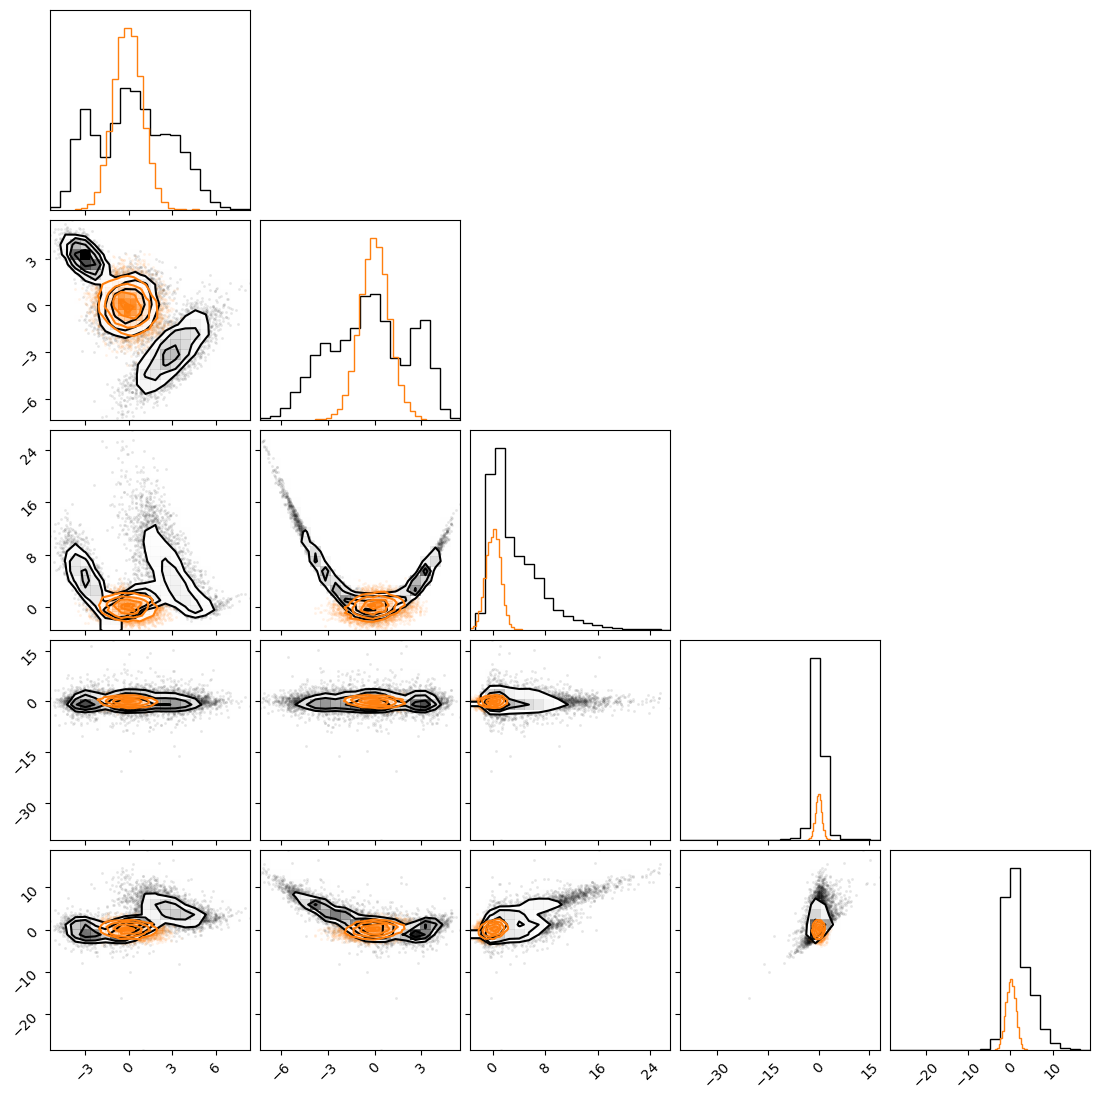

In [13]:
fig = corner.corner(np.array(samples))
fig = corner.corner(np.array(q_samples), color='C1', fig=fig)

Yikes. Now that's not a terribly good fit to the distribution. But that was with a single flow.

In [14]:
n_param = 0
for p in flow.parameters(): 
    try: 
        n_param += p.shape[0]
    except: 
        pass
print('%i free parameters in the flow' % n_param)

10 free parameters in the flow


The single planar flow only has 10 free parameters. The major advantage of flows is that you can stack multiple of them. Lets build a normalizing flow that's a combination of multiple planar flows.

# Flows 2: Planar Flow**S** 

In [15]:
class PlanarFlows(nn.Module):
    """ Stack multiple planar flows
    """
    def __init__(self, dim, num_flows):
        super().__init__()
        self.dim = dim
        self.flows = nn.ModuleList([PlanarFlow(dim) for _ in range(num_flows)])

    def forward(self, x):
        """
        """
        z = x
        sum_log_det = torch.zeros(z.size(0), device=z.device)

        for flow in self.flows:
            z, log_det = flow(z)
            sum_log_det += log_det

        log_p0 = -0.5 * (self.dim * np.log(2 * np.pi) + torch.sum(z ** 2, dim=1))
        log_px = log_p0 + sum_log_det
        return z, log_px

    def log_prob(self, x):
        """
        Convenience wrapper: just return log p(x).
        """
        _, log_px = self.forward(x)
        return log_px


In [17]:
D = samples.shape[1]
lr = 1e-2
batch_size = 256
num_epochs = 200

N_flows = 50
flows = PlanarFlows(D, N_flows).to(device)

optimizer = optim.Adam(flows.parameters(), lr=lr)

# Data
x_train = samples.to(device) #torch.tensor((samples - np.mean(samples, axis=0))/np.std(samples, axis=0), device=device, dtype=torch.float32)
N_train = samples.shape[0]

num_batches = N_train // batch_size
train_losses = []
for epoch in range(1, num_epochs + 1):
    # Shuffle train data
    perm = torch.randperm(N_train, device=device)
    x_train = x_train[perm]

    flows.train()
    epoch_loss = 0.0

    for i in range(num_batches):
        batch_x = x_train[i * batch_size:(i + 1) * batch_size]
        optimizer.zero_grad()
        lp = flows.log_prob(batch_x)      # [batch]
        loss = -lp.mean()                  # NLL
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= num_batches
    train_losses.append(epoch_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: train log p = {epoch_loss:.4f}")

Epoch 001: train log p = 45.3071
Epoch 005: train log p = 9.0581
Epoch 010: train log p = 8.3363
Epoch 015: train log p = 7.9741
Epoch 020: train log p = 7.7665
Epoch 025: train log p = 7.5591
Epoch 030: train log p = 7.4639
Epoch 035: train log p = 7.3992
Epoch 040: train log p = 7.3262
Epoch 045: train log p = 7.2930
Epoch 050: train log p = 7.2292
Epoch 055: train log p = 7.2262
Epoch 060: train log p = 7.1771
Epoch 065: train log p = 7.1443
Epoch 070: train log p = 7.1242
Epoch 075: train log p = 7.0915
Epoch 080: train log p = 7.1093
Epoch 085: train log p = 7.1182
Epoch 090: train log p = 7.0924
Epoch 095: train log p = 7.1021
Epoch 100: train log p = 7.0339
Epoch 105: train log p = 7.0155
Epoch 110: train log p = 7.0346
Epoch 115: train log p = 7.0312
Epoch 120: train log p = 7.0193
Epoch 125: train log p = 7.0350
Epoch 130: train log p = 6.9744
Epoch 135: train log p = 6.9823
Epoch 140: train log p = 6.9859
Epoch 145: train log p = 6.9545
Epoch 150: train log p = 6.9925
Epoch 1

In [37]:
flows.eval()
with torch.no_grad():
    z_samples = torch.randn((10000,5)).to(device)
    q_samples, _ = flows.forward(z_samples)
q_samples = q_samples.cpu()

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_59633/2257445245.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))
/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_59633/2257445245.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples), color='C1', fig=fig)


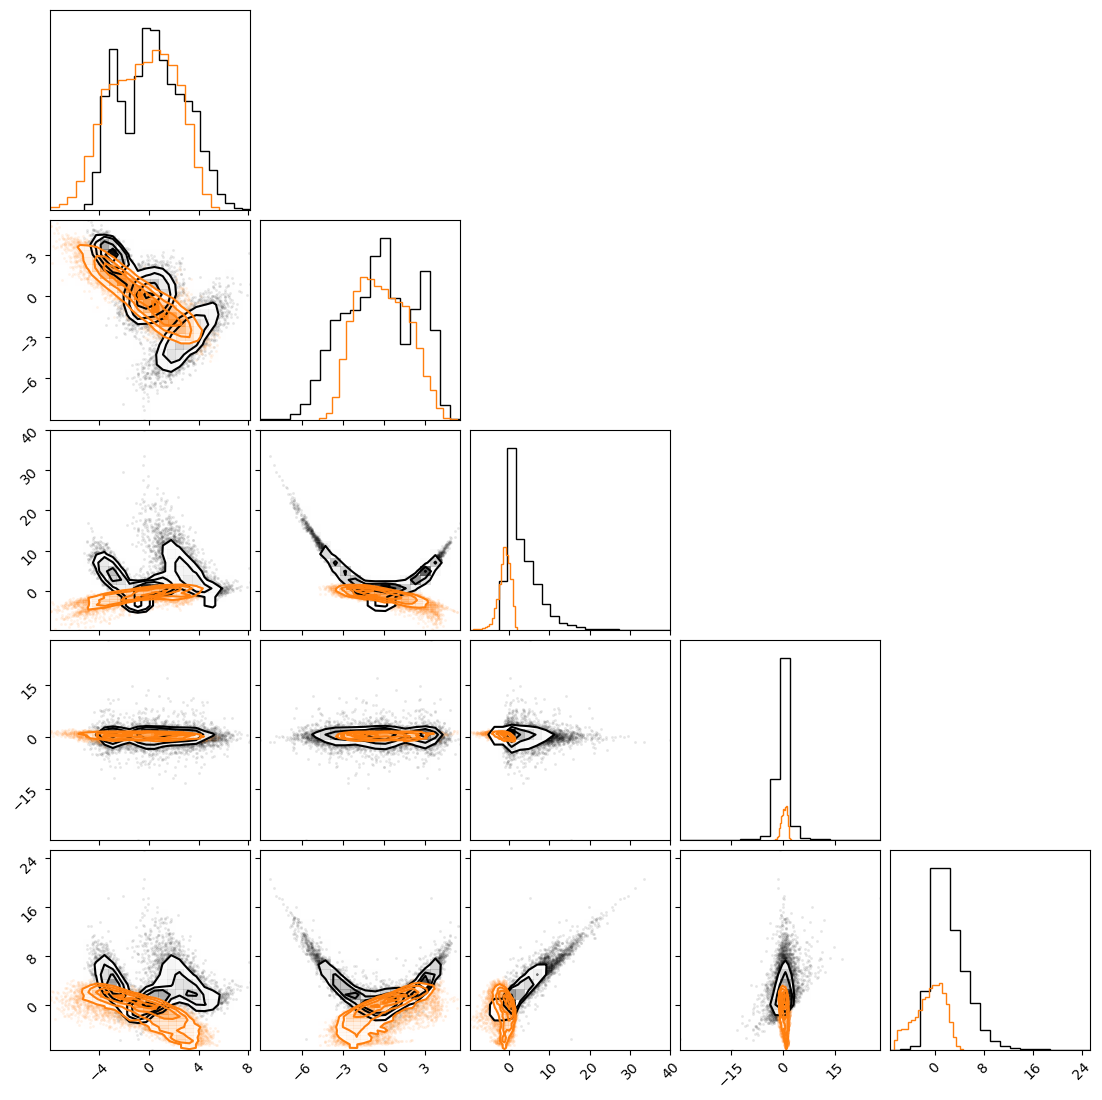

In [38]:
fig = corner.corner(np.array(samples))
fig = corner.corner(np.array(q_samples), color='C1', fig=fig)

In [42]:
n_param = 0
for p in flows.parameters(): 
    try: 
        n_param += p.shape[0]
    except: 
        pass
print(n_param)

500


# Masked Autoregressive Flows

In [5]:
def create_masks(D, hidden_dims, device="cpu"):
    """ Create autoregressive masks for MADE
    """
    # Degrees for input layer: 1, 2, ..., D
    input_degrees = torch.arange(1, D + 1, device=device)

    # Degrees for hidden layers in [1, D-1]
    degrees = []
    for h in hidden_dims:
        # For each hidden unit, sample an integer degree in [1, D-1]
        deg = torch.randint(1, D, size=(h,), device=device)
        degrees.append(deg)

    # Output layer degrees
    output_degrees = torch.arange(1, D + 1, device=device).repeat_interleave(2)

    layer_sizes = [D] + hidden_dims + [D * 2]
    all_degrees = [input_degrees] + degrees + [output_degrees]

    masks = []
    for l in range(len(layer_sizes) - 1):
        d_in = all_degrees[l]      # [n_in]
        d_out = all_degrees[l + 1] # [n_out]
        # We want mask of shape [n_out, n_in] to match Linear's [out, in]
        if l < len(layer_sizes) - 2:
            # Hidden layers: allow if d_out >= d_in
            mask = (d_out[:, None] >= d_in[None, :]).float()
        else:
            # Output layer: allow if d_out > d_in
            mask = (d_out[:, None] > d_in[None, :]).float()

        masks.append(mask)

    return masks


class MaskedLinear(nn.Linear):
    """
    Linear layer with a fixed (non-trainable) mask on the weights.
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer("mask", torch.ones(out_features, in_features))

    def set_mask(self, mask):
        # mask shape [out_features, in_features]
        self.mask.data.copy_(mask)

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, D, hidden_dims, out_per_dim=2, device="cpu"):
        super().__init__()
        self.D = D
        self.hidden_dims = hidden_dims
        self.out_per_dim = out_per_dim

        layer_sizes = [D] + hidden_dims + [D * out_per_dim]

        layers = []
        for in_f, out_f in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(MaskedLinear(in_f, out_f))
        self.layers = nn.ModuleList(layers)

        # Build and set masks
        masks = create_masks(D, hidden_dims, device=device)
        for layer, mask in zip(self.layers, masks):
            layer.set_mask(mask)

        # Init weights
        for layer in self.layers:
            nn.init.normal_(layer.weight, mean=0.0, std=1.0 / np.sqrt(layer.in_features))
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        """
        x: [batch, D]
        returns:
          m:      [batch, D]
          log_s:  [batch, D]
        """
        h = x
        L = len(self.layers)
        for l, layer in enumerate(self.layers):
            h = layer(h)
            if l < L - 1:
                h = torch.tanh(h)   # nonlinear only in hidden layers

        B = h.size(0)
        h = h.view(B, self.D, self.out_per_dim)
        m = h[..., 0]
        log_s = h[..., 1]
        return m, log_s

In [6]:
class MAFBlock(nn.Module):
    """single MAF layer
    """
    def __init__(self, D, hidden_dims, use_permutation=True, device="cpu"):
        super().__init__()
        self.D = D
        self.use_permutation = use_permutation

        self.net = MADE(D, hidden_dims, device=device)

        if use_permutation:
            perm = torch.randperm(D)
            inv_perm = torch.argsort(perm)
            self.register_buffer("perm", perm)
            self.register_buffer("inv_perm", inv_perm)
        else:
            self.perm = None
            self.inv_perm = None

    def forward(self, x):
        """
        x: [batch, D]
        Returns:
          z: [batch, D]
          log_det: [batch]
        """
        if self.use_permutation:
            x_perm = x[:, self.perm]
        else:
            x_perm = x

        m, log_s = self.net(x_perm)          # [B, D], [B, D]

        z_perm = (x_perm - m) * torch.exp(-log_s)
        log_det = -torch.sum(log_s, dim=1)

        if self.use_permutation:
            z = z_perm[:, self.inv_perm]
        else:
            z = z_perm

        return z, log_det


In [7]:
class MaskedAutoregressiveFlow(nn.Module):
    """
    MAF with K autoregressive blocks and a standard Normal base.
    Direction: x -> z_K (for fast log_prob).
    """
    def __init__(self, D, hidden_dims, num_flows, device="cpu"):
        super().__init__()
        self.D = D
        self.flows = nn.ModuleList(
            [MAFBlock(D, hidden_dims, use_permutation=True, device=device)
             for _ in range(num_flows)]
        )

    def forward(self, x):
        """
        x: [batch, D]
        Returns:
          z_K: [batch, D]
          log_p_x: [batch]
        """
        z = x
        sum_log_det = torch.zeros(z.size(0), device=z.device)

        for flow in self.flows:
            z, log_det = flow(z)
            sum_log_det += log_det

        log_p0 = -0.5 * (self.D * np.log(2 * np.pi) + torch.sum(z ** 2, dim=1))
        log_px = log_p0 + sum_log_det
        return z, log_px

    def log_prob(self, x):
        """
        Convenience wrapper for log p(x).
        """
        _, log_px = self.forward(x)
        return log_px


In [19]:
D = samples.shape[1]
hidden_dims = [64, 64] # architecture of the encoder
num_flows = 10
lr = 1e-3
batch_size = 128
num_epochs = 100

maf = MaskedAutoregressiveFlow(D, hidden_dims, num_flows).to(device)

optimizer = optim.Adam(maf.parameters(), lr=lr)

# Data
x_train = samples.to(device) 
N_train = samples.shape[0]

num_batches = N_train // batch_size
train_losses = []
for epoch in range(1, num_epochs + 1):
    # Shuffle train data
    perm = torch.randperm(N_train, device=device)
    x_train = x_train[perm]

    maf.train()
    epoch_loss = 0.0

    for i in range(num_batches):
        batch_x = x_train[i * batch_size:(i + 1) * batch_size]
        optimizer.zero_grad()
        lp = maf.log_prob(batch_x)      # [batch]
        loss = -lp.mean()                  # NLL
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= num_batches
    train_losses.append(epoch_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: train log p = {epoch_loss:.4f}")

Epoch 001: train log p = 11.6369
Epoch 005: train log p = 7.3891
Epoch 010: train log p = 6.9960
Epoch 015: train log p = 6.8909
Epoch 020: train log p = 6.8621
Epoch 025: train log p = 6.7999
Epoch 030: train log p = 6.8097
Epoch 035: train log p = 6.8332
Epoch 040: train log p = 6.7546
Epoch 045: train log p = 6.7379
Epoch 050: train log p = 6.7111
Epoch 055: train log p = 6.7110
Epoch 060: train log p = 6.6726
Epoch 065: train log p = 6.6736
Epoch 070: train log p = 6.6564
Epoch 075: train log p = 6.6603
Epoch 080: train log p = 6.6728
Epoch 085: train log p = 6.6405
Epoch 090: train log p = 6.6311
Epoch 095: train log p = 6.6491
Epoch 100: train log p = 6.6190


In [20]:
maf.eval()
with torch.no_grad():
    z_samples = torch.randn((10000,5)).to(device)
    q_samples, _ = maf.forward(z_samples)
q_samples = q_samples.cpu()

/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_73370/2257445245.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(samples))
/var/folders/4_/4m4zwzzs30518t13kpqjy7k80000gn/T/ipykernel_73370/2257445245.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  fig = corner.corner(np.array(q_samples), color='C1', fig=fig)


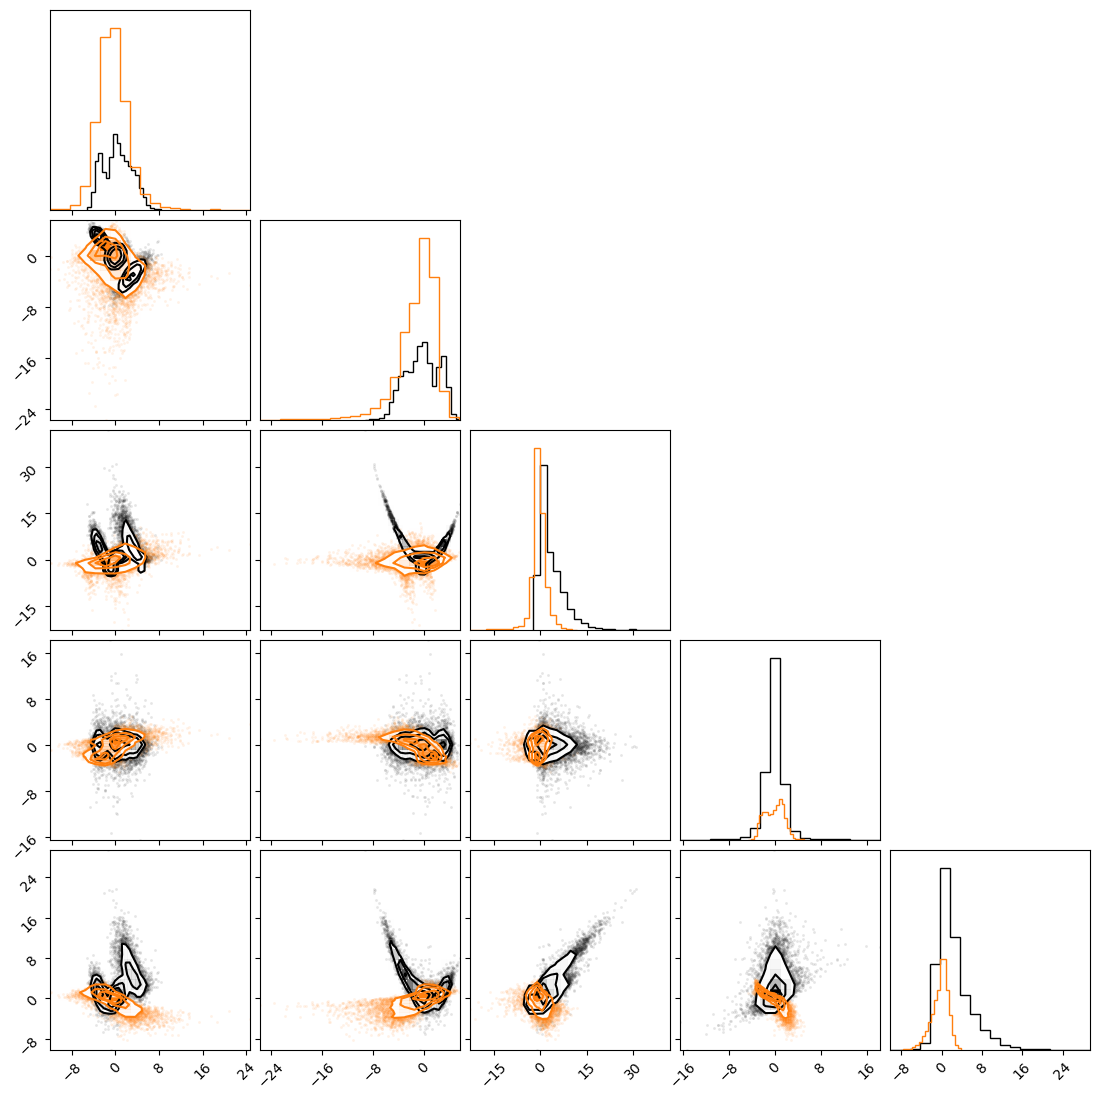

In [21]:
fig = corner.corner(np.array(samples))
fig = corner.corner(np.array(q_samples), color='C1', fig=fig)